<a href="https://colab.research.google.com/github/isabellacadisco/Human_Value_Detection_P2/blob/main/tests/P2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install -q -U transformers datasets evaluate accelerate
#%pip install optuna

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
petastorm 0.12.1 requires pyspark>=2.1.0, which is not installed.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [ ]:
dbutils.library.restartPython()

In [ ]:
# Importing stock ml libraries
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
from transformers import AutoTokenizer, AutoModel

# for viz
import matplotlib.pyplot as plt

# Preparing for TPU usage
# import torch_xla
# import torch_xla.core.xla_model as xm
# device = xm.xla_device()
import copy


2024-05-18 12:48:50.892758: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 12:48:50.892820: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 12:48:50.892845: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-18 12:48:50.899321: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# # Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
!nvidia-smi

Sat May 18 12:49:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000001:00:00.0 Off |                  Off |
| N/A   34C    P8               9W /  70W |      5MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# train
arg_training = pd.read_csv("/dbfs/mnt/tesi/hs/data_ir/arguments-training.tsv", delimiter='\t')
label_training = pd.read_csv("/dbfs/mnt/tesi/hs/data_ir/labels-training.tsv", delimiter= '\t')
df_training = pd.merge(arg_training, label_training, how='left', on="Argument ID")

In [ ]:
# validation
arg_validation = pd.read_csv("/dbfs/mnt/tesi/hs/data_ir/arguments-validation.tsv", delimiter='\t')
label_validation = pd.read_csv("/dbfs/mnt/tesi/hs/data_ir/labels-validation.tsv", delimiter= '\t')
df_validation = pd.merge(arg_validation, label_validation, how='left', on="Argument ID")



In [ ]:
df_training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5393 entries, 0 to 5392
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Argument ID                 5393 non-null   object
 1   Conclusion                  5393 non-null   object
 2   Stance                      5393 non-null   object
 3   Premise                     5393 non-null   object
 4   Self-direction: thought     5393 non-null   int64 
 5   Self-direction: action      5393 non-null   int64 
 6   Stimulation                 5393 non-null   int64 
 7   Hedonism                    5393 non-null   int64 
 8   Achievement                 5393 non-null   int64 
 9   Power: dominance            5393 non-null   int64 
 10  Power: resources            5393 non-null   int64 
 11  Face                        5393 non-null   int64 
 12  Security: personal          5393 non-null   int64 
 13  Security: societal          5393 non-null   int6

In [ ]:
df_validation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1896 entries, 0 to 1895
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Argument ID                 1896 non-null   object
 1   Conclusion                  1896 non-null   object
 2   Stance                      1896 non-null   object
 3   Premise                     1896 non-null   object
 4   Self-direction: thought     1896 non-null   int64 
 5   Self-direction: action      1896 non-null   int64 
 6   Stimulation                 1896 non-null   int64 
 7   Hedonism                    1896 non-null   int64 
 8   Achievement                 1896 non-null   int64 
 9   Power: dominance            1896 non-null   int64 
 10  Power: resources            1896 non-null   int64 
 11  Face                        1896 non-null   int64 
 12  Security: personal          1896 non-null   int64 
 13  Security: societal          1896 non-null   int6

In [ ]:
df_merged = df_training.append(df_validation, ignore_index=True)

/root/.ipykernel/1485/command-3585659305476833-3482145072:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_merged = df_training.append(df_validation, ignore_index=True)


In [ ]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7289 entries, 0 to 7288
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Argument ID                 7289 non-null   object
 1   Conclusion                  7289 non-null   object
 2   Stance                      7289 non-null   object
 3   Premise                     7289 non-null   object
 4   Self-direction: thought     7289 non-null   int64 
 5   Self-direction: action      7289 non-null   int64 
 6   Stimulation                 7289 non-null   int64 
 7   Hedonism                    7289 non-null   int64 
 8   Achievement                 7289 non-null   int64 
 9   Power: dominance            7289 non-null   int64 
 10  Power: resources            7289 non-null   int64 
 11  Face                        7289 non-null   int64 
 12  Security: personal          7289 non-null   int64 
 13  Security: societal          7289 non-null   int6

In [ ]:
df_training = df_merged

In [ ]:
!nvidia-smi

Sat May 18 12:49:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000001:00:00.0 Off |                  Off |
| N/A   33C    P8               9W /  70W |      5MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
df_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7289 entries, 0 to 7288
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Argument ID                 7289 non-null   object
 1   Conclusion                  7289 non-null   object
 2   Stance                      7289 non-null   object
 3   Premise                     7289 non-null   object
 4   Self-direction: thought     7289 non-null   int64 
 5   Self-direction: action      7289 non-null   int64 
 6   Stimulation                 7289 non-null   int64 
 7   Hedonism                    7289 non-null   int64 
 8   Achievement                 7289 non-null   int64 
 9   Power: dominance            7289 non-null   int64 
 10  Power: resources            7289 non-null   int64 
 11  Face                        7289 non-null   int64 
 12  Security: personal          7289 non-null   int64 
 13  Security: societal          7289 non-null   int6

In [ ]:
# test
arg_test = pd.read_csv("/dbfs/mnt/tesi/hs/data_ir/arguments-test.tsv", delimiter='\t')
label_test = pd.read_csv("/dbfs/mnt/tesi/hs/data_ir/labels-test.tsv", delimiter= '\t')
df_test = pd.merge(arg_test, label_test, how='left', on="Argument ID")

In [ ]:
selected_col = ['Argument ID', 'Conclusion', 'Stance', 'Premise','Self-direction: action', 'Achievement', 'Security: personal', 'Security: societal', 'Benevolence: caring', 'Universalism: concern']

subset_train = df_training[selected_col]
#subset_val = df_validation[selected_col]
subset_test = df_test[selected_col]


In [ ]:
subset_train.head(1)

,Argument ID,Conclusion,Stance,Premise,Self-direction: action,Achievement,Security: personal,Security: societal,Benevolence: caring,Universalism: concern
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,0,0,0,1,0,0


In [ ]:
subset_train = subset_train.copy()
subset_train['Text'] = subset_train['Stance'] + " " + subset_train['Conclusion'] + " " + subset_train['Premise']
subset_train.drop(labels=['Argument ID','Conclusion','Premise','Stance'], axis=1, inplace=True)

In [ ]:
subset_train.head(1)

,Self-direction: action,Achievement,Security: personal,Security: societal,Benevolence: caring,Universalism: concern,Text
0,0,0,0,1,0,0,in favor of We should ban human cloning we sho...


In [ ]:
subset_train['list'] = subset_train[subset_train.columns[:6]].values.tolist()
train_set = subset_train[['Text', 'list']].copy()
train_set.head()

,Text,list
0,in favor of We should ban human cloning we sho...,"[0, 0, 0, 1, 0, 0]"
1,in favor of We should ban fast food fast food ...,"[0, 0, 1, 0, 0, 0]"
2,against We should end the use of economic sanc...,"[0, 0, 0, 1, 0, 0]"
3,against We should abolish capital punishment c...,"[0, 0, 0, 1, 0, 1]"
4,against We should ban factory farming factory ...,"[0, 0, 1, 0, 1, 1]"


In [ ]:
subset_test = subset_test.copy()
subset_test['Text'] = subset_test['Stance'] + " " + subset_test['Conclusion'] + " " + subset_test['Premise']
subset_test.drop(labels=['Argument ID','Conclusion','Premise','Stance'], axis=1, inplace=True)

In [ ]:
subset_test.head(1)

,Self-direction: action,Achievement,Security: personal,Security: societal,Benevolence: caring,Universalism: concern,Text
0,0,1,1,0,0,1,against We should end affirmative action affir...


In [ ]:
subset_test['list'] = subset_test[subset_test.columns[:6]].values.tolist()
test_set = subset_test[['Text', 'list']].copy()
test_set.head()

,Text,list
0,against We should end affirmative action affir...,"[0, 1, 1, 0, 0, 1]"
1,in favor of We should end affirmative action a...,"[0, 1, 0, 0, 0, 1]"
2,in favor of We should ban naturopathy naturopa...,"[0, 1, 1, 0, 0, 1]"
3,in favor of We should prohibit women in combat...,"[0, 1, 0, 0, 0, 0]"
4,in favor of We should ban naturopathy once era...,"[0, 1, 1, 1, 1, 0]"


In [ ]:
# try DISTILBERT
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('distilbert/distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9065445b-4587-46a7-a0ef-6e2dc22968da/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def max_text_length(df):
  df['length'] = df['Text'].apply(lambda x: len(tokenizer.encode(x)))
  max_length = df['length'].max()
  return max_length

In [ ]:
max_text_length(train_set)

171

In [ ]:
max_text_length(test_set)

189

In [ ]:
# variables that will be used later on in the training
MAX_LEN = 189
TRAIN_BATCH_SIZE = 32 #aumentare a 32 (eventualmente vedere 64)
VALID_BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 2e-05

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.Text = dataframe.Text
        self.targets = self.data.list
        self.max_len = max_len

    def __len__(self):
        return len(self.Text)

    def __getitem__(self, index):
        Text = str(self.Text[index])
        Text = " ".join(Text.split())

        inputs = self.tokenizer.encode_plus(
            Text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            #pad_to_max_length=True, deprecated
            padding='max_length',
            #return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        #token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            #'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
train_set = train_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)


In [ ]:
print("TRAIN Dataset: {}".format(train_set.shape))
print("TEST Dataset: {}".format(test_set.shape))

TRAIN Dataset: (7289, 3)
TEST Dataset: (1576, 3)


In [ ]:
training_set = CustomDataset(train_set, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_set, tokenizer, MAX_LEN)


In [ ]:

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
import torch
import transformers

class DistilBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistilBERTClass, self).__init__()
        self.l1 = transformers.DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 6)

    def forward(self, ids, mask):
        outputs = self.l1(ids, attention_mask=mask)
        output_1 = outputs.last_hidden_state[:, 0, :]  # DistilBERT doesn't have pooler_output; use the [CLS] token

        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = DistilBERTClass()
model.to(device)


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.1)

In [ ]:
# LR scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.01)

In [ ]:
def train(epoch):
    model.train()

    losses = []

    t_fin_targets=[]
    t_fin_outputs=[]

    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        #token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        # forward
        outputs = model(ids, mask) #, token_type_ids)

        t_fin_targets.extend(targets.cpu().detach().numpy().tolist())
        # apply SIGMOID to get multilabel predictions
        t_fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

        #optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())

        #if _%2000==0:
         #   print(f'Epoch: {epoch}, Loss:  {loss.item()}')

        # backward
        optimizer.zero_grad()
        loss.backward()
        # clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    return t_fin_outputs, t_fin_targets, np.mean(losses)

In [ ]:
def validation(epoch):
    model.eval()

    fin_targets=[]
    fin_outputs=[]

    with torch.no_grad(): #disable gradient calculation, useful for evaluation
        for _, data in enumerate(testing_loader, 0):

            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            #token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)

            outputs = model(ids, mask) #, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [ ]:
metrics_train_eval = {}

In [ ]:
for epoch in range(EPOCHS):

    print(f'Epoch: {epoch}')

    # training ----------------------------------------------------------------
    train_outputs, train_targets, train_loss = train(epoch)
    # put to 1 predictions with value >= 0.5
    train_outputs = np.array(train_outputs) >= 0.5

    train_accuracy = metrics.accuracy_score(train_targets, train_outputs)
    train_f1_score_micro = metrics.f1_score(train_targets, train_outputs, average='micro')
    train_f1_score_macro = metrics.f1_score(train_targets, train_outputs, average='macro')

    metrics_train_eval[epoch] = {'Train Accuracy Score' : train_accuracy,
                        'Train F1 Score (Micro)' : train_f1_score_micro,
                        'Train F1 Score (Macro)' : train_f1_score_macro}

    print(f"Train Accuracy Score = {train_accuracy}")
    print(f"Train F1 Score (Micro) = {train_f1_score_micro}")
    print(f"Train F1 Score (Macro) = {train_f1_score_macro}")
    print(f"Train loss = {train_loss}")


    # validation --------------------------------------------------------------

    eval_outputs, eval_targets = validation(epoch)
    # put to 1 predictions with value >= 0.5
    eval_outputs = np.array(eval_outputs) >= 0.5

    eval_accuracy = metrics.accuracy_score(eval_targets, eval_outputs)
    eval_f1_score_micro = metrics.f1_score(eval_targets, eval_outputs, average='micro')
    eval_f1_score_macro = metrics.f1_score(eval_targets, eval_outputs, average='macro')

    metrics_train_eval[epoch].update({
        'Eval Accuracy Score': eval_accuracy,
        'Eval F1 Score (Micro)': eval_f1_score_micro,
        'Eval F1 Score (Macro)': eval_f1_score_macro
    })

    print(f"Eval Accuracy Score = {eval_accuracy}")
    print(f"Eval F1 Score (Micro) = {eval_f1_score_micro}")
    print(f"Eval F1 Score (Macro) = {eval_f1_score_macro}")

    # Adjust the learning rate
    #scheduler.step()

    print('-------------------------------------------------------------------')

Epoch: 0
Train Accuracy Score = 0.19316778707641652
Train F1 Score (Micro) = 0.4623540856031128
Train F1 Score (Macro) = 0.43469021758934145
Train loss = 0.5248795203995287
Eval Accuracy Score = 0.25
Eval F1 Score (Micro) = 0.6008719778042014
Eval F1 Score (Macro) = 0.5726316176815321
-------------------------------------------------------------------
Epoch: 1
Train Accuracy Score = 0.28851694333927835
Train F1 Score (Micro) = 0.6366811124668658
Train F1 Score (Macro) = 0.616465848212889
Train loss = 0.4365006941452361
Eval Accuracy Score = 0.2893401015228426
Eval F1 Score (Micro) = 0.6143273635985006
Eval F1 Score (Macro) = 0.5878124038183544
-------------------------------------------------------------------
Epoch: 2
Train Accuracy Score = 0.34929345589244065
Train F1 Score (Micro) = 0.7024867509172441
Train F1 Score (Macro) = 0.6878058262043778
Train loss = 0.3844891156543765
Eval Accuracy Score = 0.28045685279187815
Eval F1 Score (Micro) = 0.6330203442879498
Eval F1 Score (Macro) =

In [ ]:
metrics.accuracy_score(eval_targets, eval_outputs)

0.2614213197969543

è possibile che la calcoli considerando i vettori di predizioni come elementi da confrontare

In [ ]:
metrics.accuracy_score([0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [ True, False, False, False, False,  True])

0.5

In [ ]:
metrics.accuracy_score([[0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0]], [[ True, False, False, False, False,  True], [ True, False, False, False, False,  True]])

0.0

In [ ]:
metrics.accuracy_score([[1,0,1], [1,0, 1]], [[True,False, False], [True,False, False]])

0.0

Accuracy score con vettori confronta gli elementi come unici

In [ ]:
metrics.accuracy_score([1,0,1,1,0, 1], [True,False, False, True,False, False])

0.6666666666666666

In [ ]:
metrics.accuracy_score([1,0,1], [True,False, False])

0.6666666666666666

In [ ]:
metrics.f1_score([[1,0,1], [1,0, 1]], [[True,False, False], [True,False, False]], average='micro')

0.6666666666666666

In [ ]:
metrics.f1_score([[1,0,1], [1,0, 1]], [[True,False, False], [True,False, False]], average='macro')

/databricks/python/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


0.3333333333333333

In [ ]:
metrics.accuracy_score([1,0,1],[True,False, False])

0.6666666666666666

In [ ]:
eval_outputs

array([[ True, False, False, False, False,  True],
       [False, False,  True,  True, False, False],
       [ True, False, False, False, False, False],
       ...,
       [False, False,  True, False, False,  True],
       [False,  True, False, False, False, False],
       [False, False,  True, False, False, False]])

In [ ]:
eval_targets

[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, 1.0, 1.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, 0.0, 1.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 1.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 1.0, 0.0, 1.0, 1.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 1.0, 0.0, 1.0, 0.0],
 [0.0, 1.0, 0.0, 1.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 1.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 1.0, 0.0, 0.0, 1.0],
 [1.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 1.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 [0.0, 0.0

In [ ]:
# eval_outputs

n_labels = 6
value_col = selected_col[4:]

f1 = dict()

In [ ]:
e_t = np.array(eval_targets)

In [ ]:
e_p = np.array(eval_outputs)

In [ ]:
metrics.accuracy_score(e_t, e_p)

0.2614213197969543

In [ ]:
for i in range(n_labels):
  f1[value_col[i]] = metrics.f1_score(e_t[:, i], e_p[:, i], average='binary')

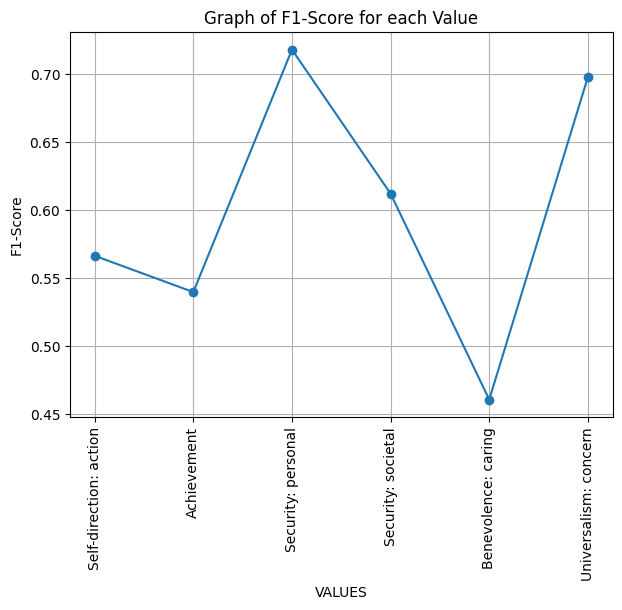

In [ ]:
plt.figure(figsize=(7, 5))

plt.plot(list(f1.keys()), list(f1.values()), marker='o')

plt.xlabel('VALUES')
plt.xticks(rotation='vertical')

plt.ylabel('F1-Score')
plt.title('Graph of F1-Score for each Value')

plt.grid(True)
plt.show()

In [ ]:
acc = dict()

In [ ]:
for i in range(n_labels):
  acc[value_col[i]] = metrics.accuracy_score(e_t[:, i], e_p[:, i])

In [ ]:
metrics.accuracy_score(e_t[:, i], e_p[:, i]) == metrics.f1_score(e_t[:, i], e_p[:, i], average='binary')

False

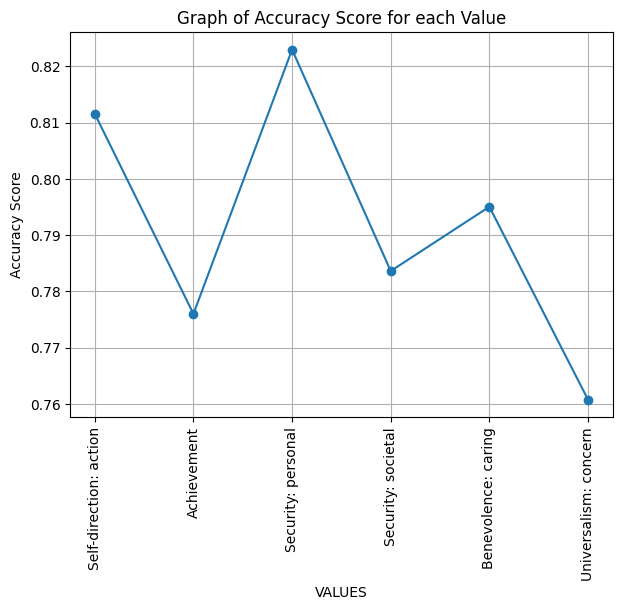

In [ ]:
plt.figure(figsize=(7, 5))

plt.plot(list(acc.keys()), list(acc.values()), marker='o')

plt.xlabel('VALUES')
plt.xticks(rotation='vertical')

plt.ylabel('Accuracy Score')
plt.title('Graph of Accuracy Score for each Value')

plt.grid(True)
plt.show()

In [ ]:
import statistics

In [ ]:
statistics.mean(list(acc.values()))

0.7916666666666666

In [ ]:
metrics_train_eval

{0: {'Train Accuracy Score': 0.19316778707641652,
  'Train F1 Score (Micro)': 0.4623540856031128,
  'Train F1 Score (Macro)': 0.43469021758934145,
  'Eval Accuracy Score': 0.25,
  'Eval F1 Score (Micro)': 0.6008719778042014,
  'Eval F1 Score (Macro)': 0.5726316176815321},
 1: {'Train Accuracy Score': 0.28851694333927835,
  'Train F1 Score (Micro)': 0.6366811124668658,
  'Train F1 Score (Macro)': 0.616465848212889,
  'Eval Accuracy Score': 0.2893401015228426,
  'Eval F1 Score (Micro)': 0.6143273635985006,
  'Eval F1 Score (Macro)': 0.5878124038183544},
 2: {'Train Accuracy Score': 0.34929345589244065,
  'Train F1 Score (Micro)': 0.7024867509172441,
  'Train F1 Score (Macro)': 0.6878058262043778,
  'Eval Accuracy Score': 0.28045685279187815,
  'Eval F1 Score (Micro)': 0.6330203442879498,
  'Eval F1 Score (Macro)': 0.6049233538691109},
 3: {'Train Accuracy Score': 0.42022225270956237,
  'Train F1 Score (Micro)': 0.7566301413371446,
  'Train F1 Score (Macro)': 0.7450719239467655,
  'Eval A

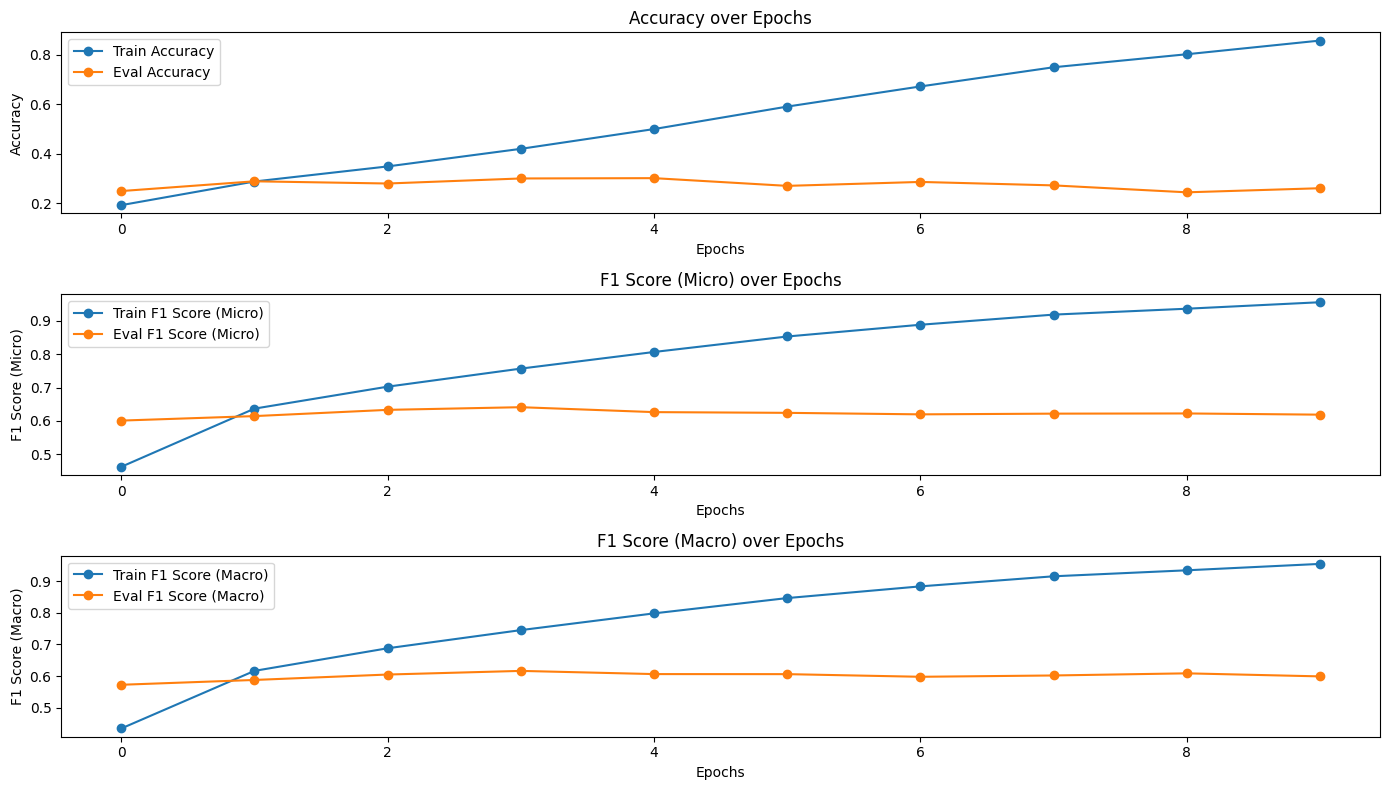

In [ ]:
# extract metrics
epochs = list(metrics_train_eval.keys())
train_accuracy = [metrics_train_eval[epoch]['Train Accuracy Score'] for epoch in epochs]
eval_accuracy = [metrics_train_eval[epoch]['Eval Accuracy Score'] for epoch in epochs]
train_f1_micro = [metrics_train_eval[epoch]['Train F1 Score (Micro)'] for epoch in epochs]
eval_f1_micro = [metrics_train_eval[epoch]['Eval F1 Score (Micro)'] for epoch in epochs]
train_f1_macro = [metrics_train_eval[epoch]['Train F1 Score (Macro)'] for epoch in epochs]
eval_f1_macro = [metrics_train_eval[epoch]['Eval F1 Score (Macro)'] for epoch in epochs]

# plot fig
plt.figure(figsize=(14, 8))

# accuracy plot
plt.subplot(3, 1, 1)
plt.plot(epochs, train_accuracy, label='Train Accuracy', marker='o')
plt.plot(epochs, eval_accuracy, label='Eval Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# F1 micro plot
plt.subplot(3, 1, 2)
plt.plot(epochs, train_f1_micro, label='Train F1 Score (Micro)', marker='o')
plt.plot(epochs, eval_f1_micro, label='Eval F1 Score (Micro)', marker='o')
plt.title('F1 Score (Micro) over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score (Micro)')
plt.legend()

# F1 macro plot
plt.subplot(3, 1, 3)
plt.plot(epochs, train_f1_macro, label='Train F1 Score (Macro)', marker='o')
plt.plot(epochs, eval_f1_macro, label='Eval F1 Score (Macro)', marker='o')
plt.title('F1 Score (Macro) over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score (Macro)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
selected_col[4:]

['Self-direction: action',
 'Achievement',
 'Security: personal',
 'Security: societal',
 'Benevolence: caring',
 'Universalism: concern']

In [ ]:
test_set.head(1)

,Text,list
0,against We should end affirmative action affir...,"[0, 1, 1, 0, 0, 1]"


In [ ]:
test_item_0 = testing_set.__getitem__(0)
ids = test_item_0['ids'].to(device, dtype = torch.long)
mask = test_item_0['mask'].to(device, dtype = torch.long)
#token_type_ids = test_item_0['token_type_ids'].to(device, dtype = torch.long)
targets = test_item_0['targets'] #

# disable gradient calculation, add an extra dimension to the input tensors using unsqueeze(0) to create a batch of size 1.
with torch.no_grad():
    outputs = model(ids.unsqueeze(0), mask.unsqueeze(0)) #, token_type_ids.unsqueeze(0))

print("Model Output:", outputs)

outputs = torch.sigmoid(outputs).cpu().detach().numpy().tolist()
print("Model Output after SIGMOID:", outputs)

outputs = np.array(outputs) >= 0.5

# model's output and the actual target
print("Model Output threshold:", outputs)
print("Actual Target:", targets)

Model Output: tensor([[-2.6299,  1.6202,  0.7199, -2.4349,  0.4053, -0.5044]],
       device='cuda:0')
Model Output after SIGMOID: [[0.06724177300930023, 0.8348291516304016, 0.6725941300392151, 0.08054693043231964, 0.5999504327774048, 0.37650883197784424]]
Model Output threshold: [[False  True  True False  True False]]
Actual Target: tensor([0., 1., 1., 0., 0., 1.])


In [ ]:
# flat the outputs and targets arrays
outputs_flat = np.ravel(outputs)
targets_flat = np.ravel(targets)

print("Accuracy Score:", metrics.accuracy_score(targets_flat, outputs_flat))
print("F1 micro Score:", metrics.f1_score(targets_flat, outputs_flat, average='micro'))
print("F1 macro Score:", metrics.f1_score(targets_flat, outputs_flat, average='macro'))

Accuracy Score: 0.6666666666666666
F1 micro Score: 0.6666666666666666
F1 macro Score: 0.6666666666666666


In [ ]:
test_set[87:88]

,Text,list
87,in favor of We should abandon marriage marriag...,"[0, 0, 1, 0, 0, 1]"


In [ ]:
test_item_0 = testing_set.__getitem__(87)
ids = test_item_0['ids'].to(device, dtype = torch.long)
mask = test_item_0['mask'].to(device, dtype = torch.long)
#token_type_ids = test_item_0['token_type_ids'].to(device, dtype = torch.long)
targets = test_item_0['targets'] #

# disable gradient calculation, add an extra dimension to the input tensors using unsqueeze(0) to create a batch of size 1.
with torch.no_grad():
    outputs = model(ids.unsqueeze(0), mask.unsqueeze(0)) #, token_type_ids.unsqueeze(0))

print("Model Output:", outputs)

outputs = torch.sigmoid(outputs).cpu().detach().numpy().tolist()
print("Model Output after SIGMOID:", outputs)

outputs = np.array(outputs) >= 0.5

# model's output and the actual target
print("Model Output threshold:", outputs)
print("Actual Target:", targets)

Model Output: tensor([[-3.3091, -0.5833, -0.9000, -1.7042, -1.4754,  0.5591]],
       device='cuda:0')
Model Output after SIGMOID: [[0.03525879234075546, 0.35817810893058777, 0.2890597879886627, 0.15391238033771515, 0.18612763285636902, 0.63625168800354]]
Model Output threshold: [[False False False False False  True]]
Actual Target: tensor([0., 0., 1., 0., 0., 1.])


In [ ]:
# flat the outputs and targets arrays
outputs_flat = np.ravel(outputs)
targets_flat = np.ravel(targets)

print("Accuracy Score:", metrics.accuracy_score(targets_flat, outputs_flat))
print("F1 micro Score:", metrics.f1_score(targets_flat, outputs_flat, average='micro'))
print("F1 macro Score:", metrics.f1_score(targets_flat, outputs_flat, average='macro'))

Accuracy Score: 0.8333333333333334
F1 micro Score: 0.8333333333333334
F1 macro Score: 0.7777777777777778


In [ ]:
test_set[1456:1457]

,Text,list
1456,"against We should get migration from Asia, and...","[0, 0, 0, 0, 0, 0]"


In [ ]:
test_item_0 = testing_set.__getitem__(1456)
ids = test_item_0['ids'].to(device, dtype = torch.long)
mask = test_item_0['mask'].to(device, dtype = torch.long)
#token_type_ids = test_item_0['token_type_ids'].to(device, dtype = torch.long)
targets = test_item_0['targets'] #

# disable gradient calculation, add an extra dimension to the input tensors using unsqueeze(0) to create a batch of size 1.
with torch.no_grad():
    outputs = model(ids.unsqueeze(0), mask.unsqueeze(0)) #, token_type_ids.unsqueeze(0))

print("Model Output:", outputs)

outputs = torch.sigmoid(outputs).cpu().detach().numpy().tolist()
print("Model Output after SIGMOID:", outputs)

outputs = np.array(outputs) >= 0.5

# model's output and the actual target
print("Model Output threshold:", outputs)
print("Actual Target:", targets)

Model Output: tensor([[-2.5308,  0.2860,  0.2736, -0.8659, -2.4458, -3.5349]],
       device='cuda:0')
Model Output after SIGMOID: [[0.07372570037841797, 0.5710223913192749, 0.5679871439933777, 0.2961139678955078, 0.07974442094564438, 0.02833637222647667]]
Model Output threshold: [[False  True  True False False False]]
Actual Target: tensor([0., 0., 0., 0., 0., 0.])


In [ ]:
# flat the outputs and targets arrays
outputs_flat = np.ravel(outputs)
targets_flat = np.ravel(targets)

print("Accuracy Score:", metrics.accuracy_score(targets_flat, outputs_flat))
print("F1 micro Score:", metrics.f1_score(targets_flat, outputs_flat, average='micro'))
print("F1 macro Score:", metrics.f1_score(targets_flat, outputs_flat, average='macro'))

Accuracy Score: 0.6666666666666666
F1 micro Score: 0.6666666666666666
F1 macro Score: 0.4
